In [1]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
from datetime import datetime
print('import finish')

2023-05-01 07:45:55.417804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


import finish


In [2]:
datasets_dir = 'datasets'
checkpoint_dir = 'checkpoints'

In [3]:
joint_number = 5

In [4]:
datasets = []
for file_name in list(os.listdir(datasets_dir)):
    dataset = pd.read_table(f'{datasets_dir}/{file_name}', sep=' ')
    datasets.append(dataset)


In [5]:
def remove_outliers(df, column=None):
    if column is None:
        return df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df[(np.abs(stats.zscore(df[column])) < 3).all(axis=1)]

In [6]:
full_datasets = []
for dataset in datasets:
    time = dataset["time"]
    col_names_vel = [el for el in datasets[0].columns if el.startswith("Vel")]
    velocities = dataset[col_names_vel]
    diff_v = np.diff(velocities, axis=0)
    diff_t = np.diff(time, axis=0)
    col_names_acc = [el.replace("Vel", "Acc") for el in col_names_vel]
    acc = pd.DataFrame(
        np.transpose(np.transpose(diff_v) / diff_t), columns=col_names_acc
    )
    dataset_with_acc = (dataset.join(acc))[:-1]
    dataset_with_acc = remove_outliers(
        dataset_with_acc,
        column=[el for el in datasets[0].columns if el.startswith("For")],
    )
    full_datasets.append(dataset_with_acc)

In [7]:
dataset = pd.concat(full_datasets)

In [8]:
print(dataset.shape)

(513161, 21)


In [9]:
def plot_(name, df, i=0, count=-1, start=0, title=None, file_name=None, directory=None):
    if title is None:
        title = name
    col = [el for el in df.columns if el.startswith(name)]
    val = df[col]
    i = val.iloc[start : start + count, i]
    plt.plot(range(len(i)), i, ".")
    plt.title(title)

    if directory is not None:
        if not os.path.exists(directory):
            os.makedirs(directory)

    if file_name is not None:
        plt.savefig(directory + "/" + file_name)

    plt.show()


# plot_('Pos', dataset, 0)
# plot_('Vel', dataset, 0)
# plot_('Acc', dataset, 0)
# plot_(
#     "For",
#     dataset,
#     1,
#     count=1000,
#     start=1000,
#     title="Force cleaned",
# )
# for i in range(2):
#     plot_('Vel', full_datasets[0], i)

# data preprocessing

In [10]:
df = dataset
# normalize
dataset = (df-df.min())/(df.max()-df.min())
dataset.pop('time')

1     0.135863
2     0.135863
3     0.135864
4     0.135865
5     0.135866
        ...   
36    0.859873
37    0.859874
38    0.859875
39    0.859875
40    0.859876
Name: time, Length: 513161, dtype: float64

In [11]:
def split_to_x_y(table):
    X_names = [el for el in table.columns if el.startswith('Pos') or el.startswith('Vel') or el.startswith('Acc')]
    Y_names = [el for el in table.columns if el.startswith('For')]
    return table[X_names], table[Y_names]

In [12]:
# divide dataset into train and test by fraction
def split_train_test(table, fraction):
    train_size = int(len(table) * fraction)
    return table[:train_size], table[train_size:]

In [13]:
train, test = split_train_test(dataset, 0.7)
(train_x, train_y), (test_x, test_y) = split_to_x_y(train), split_to_x_y(test)

In [26]:
from keras import backend as K

def nmse(y_true, y_pred):
    return mse(y_true, y_pred) / var(y_true)

def nrmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) / (K.max(y_true) - K.min(y_true))

# variance of data
def var(y):
    return K.var(y)

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))


In [33]:
def create_model(layers):
    model = Sequential()
    # input layer
    model.add(Flatten(input_shape=((joint_number * 3),)))
    for layer in layers:
        model.add(
        Dense(
            layer,
            activation="relu",
        )
    )

    # output layer
    model.add(Dense(joint_number, activation="relu"))

    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=[
            'mse',
            nmse,
            keras.metrics.RootMeanSquaredError("rmse"),
            nrmse,
            'mae',
        ],
    )
    return model

In [36]:
layers_list = [
    [1000 for _ in range(2)]
]
# for neuron_number in [100]:
#     layers_list += [
#         [neuron_number for _ in range(layer_number)] for layer_number in range(1, 11)
#     ]

models = [create_model(layers) for layers in reversed(layers_list)]


In [37]:
print(layers_list)

[[1000, 1000]]


In [38]:
checkpoint_dir_current = (
    checkpoint_dir + "/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)

if not os.path.exists(checkpoint_dir_current):
    os.makedirs(checkpoint_dir_current)

histories = []
for i, model in enumerate(models):
    layers = layers_list[i]
    name = " ".join(map(str, layers))

    from datetime import datetime

    gen_date_str = datetime.now().strftime("-%Y-%m-%d_%H-%M-%S")

    if not os.path.exists(checkpoint_dir_current):
        os.mkdir(checkpoint_dir_current)
    if not os.path.exists(checkpoint_dir_current + "/" + name):
        os.mkdir(checkpoint_dir_current + "/" + name)

    filepath_backup = (
        checkpoint_dir_current
        + "/"
        + name
        + "/epoch-{epoch:02d}-val_mse-{val_mse:.4f}.hdf5"
    )

    checkpoint_best = keras.callbacks.ModelCheckpoint(
        filepath_backup,
        monitor="val_mse",
        mode="min",
        save_best_only=True,
        verbose=1,
    )

    histories.append(
        model.fit(
            train_x,
            train_y,
            epochs=200,
            validation_data=(test_x, test_y),
            callbacks=[
                EarlyStopping(patience=5, monitor="val_mse", mode="min"),
                checkpoint_best,
            ],
        )
    )

Epoch 1/200
11218/11226 [============================>.] - ETA: 0s - loss: 0.0133 - mse: 0.0133 - nmse: 0.1688 - rmse: 0.1154 - nrmse: 0.1152 - mae: 0.0823
Epoch 1: val_mse improved from inf to 0.00972, saving model to checkpoints/2023-05-01_10-48-03/1000 1000/epoch-01-val_mse-0.0097.hdf5
11226/11226 [==============================] - 77s 7ms/step - loss: 0.0133 - mse: 0.0133 - nmse: 0.1687 - rmse: 0.1154 - nrmse: 0.1152 - mae: 0.0823 - val_loss: 0.0097 - val_mse: 0.0097 - val_nmse: 0.1651 - val_rmse: 0.0986 - val_nrmse: 0.1240 - val_mae: 0.0684
Epoch 2/200
11225/11226 [============================>.] - ETA: 0s - loss: 0.0098 - mse: 0.0098 - nmse: 0.1237 - rmse: 0.0988 - nrmse: 0.0998 - mae: 0.0693
Epoch 2: val_mse improved from 0.00972 to 0.00931, saving model to checkpoints/2023-05-01_10-48-03/1000 1000/epoch-02-val_mse-0.0093.hdf5
11226/11226 [==============================] - 83s 7ms/step - loss: 0.0098 - mse: 0.0098 - nmse: 0.1237 - rmse: 0.0988 - nrmse: 0.0998 - mae: 0.0693 - val

KeyboardInterrupt: 

In [ ]:
for i, model in enumerate(models):
    layers = layers_list[i]
    name = dir = " ".join(map(str, layers))

    print(f"validation {name}:", model.evaluate(test_x, test_y))

4811/4811 [==============================] - 5s 1ms/step - loss: 0.0094 - mse: 0.0094 - nmse: 0.1700 - nrmse: 0.1235 - rmse: 0.0971 - mae: 0.0683
validation 100: [0.009430551901459694, 0.009430551901459694, 0.1700468361377716, 0.12346704304218292, 0.09711113572120667, 0.06832339614629745]
4811/4811 [==============================] - 7s 1ms/step - loss: 0.0091 - mse: 0.0091 - nmse: 0.1606 - nrmse: 0.1210 - rmse: 0.0955 - mae: 0.0667
validation 100 100: [0.009127280674874783, 0.009127280674874783, 0.1605512648820877, 0.12095052003860474, 0.09553684294223785, 0.06670547276735306]
4811/4811 [==============================] - 5s 1ms/step - loss: 0.0086 - mse: 0.0086 - nmse: 0.1542 - nrmse: 0.1174 - rmse: 0.0925 - mae: 0.0637
validation 100 100 100: [0.008559721522033215, 0.008559721522033215, 0.15421012043952942, 0.11742398887872696, 0.09251873940229416, 0.0636695846915245]
4811/4811 [==============================] - 5s 1ms/step - loss: 0.0093 - mse: 0.0093 - nmse: 0.1642 - nrmse: 0.1217 -

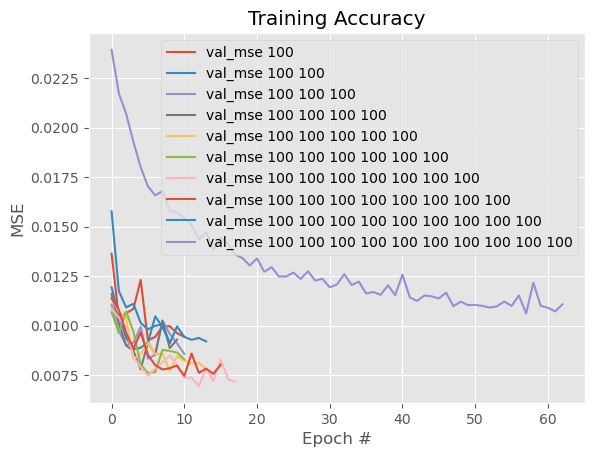

In [ ]:
plt.style.use("ggplot")
plt.figure()
for i, model in enumerate(models):
    layers = layers_list[i]
    history = histories[i]
    name = dir = " ".join(map(str, layers))

    # plot the training loss and accuracy
    epochs = len(history.history["loss"])

    plt.plot(np.arange(0, epochs),
            history.history["val_mse"], label=f"val_mse {name}")
plt.title(f"Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.legend()